In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0,'/Users/palmerio/Dropbox/Plotting_GUI/Src')
import plotting_functions as pf
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)
verbose = True
run_mode = 'debug'
import prototype_GRB_population as pt
from GRB_population import GRBPopulation
import physics as ph
import numpy as np
import io_grb_pop as io
import miscellaneous as msc
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
plt.style.use('presentation')
paths_to_dir, paths_to_files = io.generate_paths()
config, params, instruments, samples = io.read_init_files(paths_to_files)
config['output_dir'] = 'debugger'
paths_to_dir['output'] = paths_to_dir['output']/config['output_dir']

12:26:21.410 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
12:26:21.412 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
12:26:21.412 [DEBUG] File paths :
    'config'  : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'   : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum' : /Users/palmerio/Science_projects/GRB_population_model/init/instruments.yml

In [4]:
config['Nb_GRBs'] = '1e6'
config['samples'] = ['Stern', 'EpGBM', 'eBAT6','BATSE_5B_sample', 'GBM_sample', 'Swift_bright']
config
params

{'luminosity_function': {'model': 'ES',
  'logLmin': 49.6989700043,
  'logLmax': 53.0,
  'logLbreak': 52.56,
  'slope': 1.41,
  'k_evol': 1.0},
 'redshift_distribution': {'model': 'BExp',
  'zmax': 20,
  'zm': 2.18,
  'a': 0.94,
  'b': -0.52,
  'zeta': None},
 'spectral_shape': {'model': 'GBM_Band', 'alpha': 0.6, 'beta': 2.5},
 'peak_energy_distribution': {'model': 'LN',
  'Ep0': 690,
  'sigmaEp': 0.45,
  'alpha_amati': 0.3},
 't90obs_distribution': {'mu': 1.45, 'sigma': 0.47},
 'Cvar_distribution': {'mu': 0.04, 'sigma': 0.22, 'correl_slope': 0.413}}

In [5]:
cosmo = init_cosmology(paths_to_dir['cosmo'])
ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                            ECLAIRs_config=instruments['ECLAIRs'])
samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

Nb_GRBs = int(float(config['Nb_GRBs']))

incl_samples = msc.included_samples(config['samples'], samples)
incl_instruments = msc.included_instruments(incl_samples, instruments)

12:26:33.496 [DEBUG] ==============================================
12:26:33.497 [DEBUG] ===           ECLAIRs instrument           ===
12:26:33.498 [DEBUG] ==============================================
12:26:33.498 [DEBUG] ECLAIRs energy channel: 4.0 to 150.0 keV
12:26:33.499 [DEBUG] ECLAIRs detection level: 6.5 sigmas
12:26:33.528 [DEBUG] Effective area: from 1.013650e+02 cm2 at 4.00 keV
12:26:33.529 [DEBUG] Effective area: to   1.811580e+02 cm2 at 250.00 keV
12:26:33.529 [DEBUG] Background: from 2.819620e+02 cts/s/keV at 4.00 keV
12:26:33.530 [DEBUG] Background: to   8.730200e-02 cts/s/keV at 250.00 keV
12:26:33.531 [DEBUG] ECLAIRs background: 3.098396e+03 cts/s from 4.00 keV to 150.00 keV
12:26:33.532 [DEBUG] ==============================================
12:26:33.533 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'BATSE_5B_sample', 'GBM_sample', 'Swift_bright']
12:26:33.536 [DEBUG] Including samples:
BATSE_5B_sample:
    instrument: BATSE_5B
    pflx_min: 1.0
EpGBM:
    in

12:26:44.226 [INFO] Debug mode activated; plotting z pdf
12:26:44.393 [INFO] Debug mode activated; plotting L pdf
12:26:44.542 [INFO] Debug mode activated; plotting Ep pdf
12:26:44.691 [INFO] Debug mode activated; plotting t90obs pdf
12:26:44.852 [INFO] Debug mode activated; plotting Cvar pdf
12:26:45.257 [INFO] Debug mode activated; plotting spectral params pdf
===                         SUMMARY                                ===
 prop 	| median 	| stdev 	| min    	| max
---------------------------------------------------------------------- 
 z	| 2.36300e+00 	| 1.39502e+00 	| 1.80000e-02 	| 1.98380e+01 
 L	| 7.54457e+50 	| 2.28944e+52 	| 5.48991e+49 	| 2.75611e+54 
 Ep	| 6.88499e+02 	| 1.63134e+03 	| 3.75453e+00 	| 9.51857e+04 
 t90obs	| 2.81803e+01 	| 7.47413e+01 	| 1.63612e-01 	| 4.17412e+03 
 Cvar	| 2.76461e-01 	| 2.22358e-01 	| 9.87693e-03 	| 1.00000e+00 
 alpha	| 6.50022e-01 	| 3.30339e-01 	| -7.05642e-01 	| 1.72638e+00 
 beta	| 2.49859e+00 	| 4.09729e-01 	| 2.00168e+00 	| 4.048

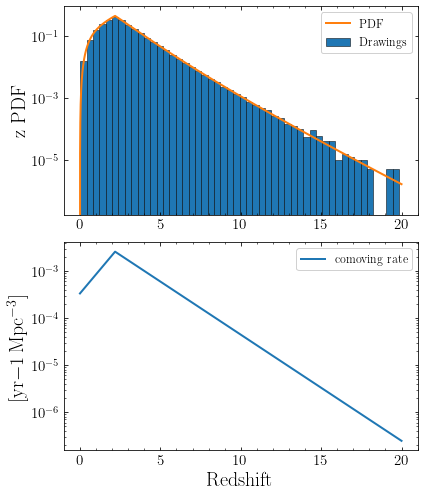

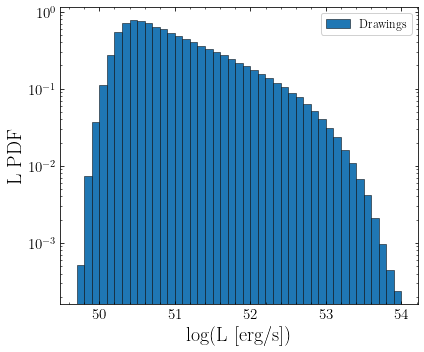

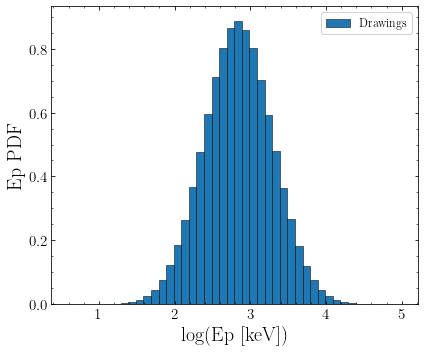

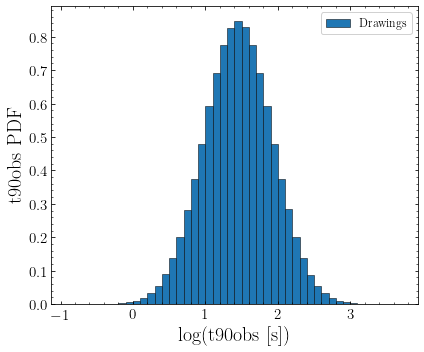

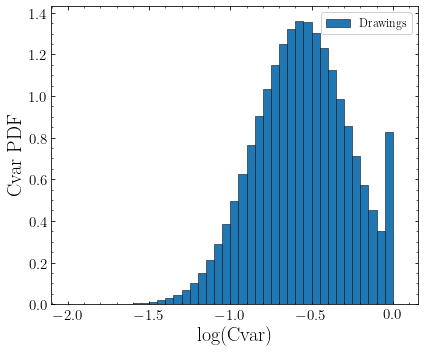

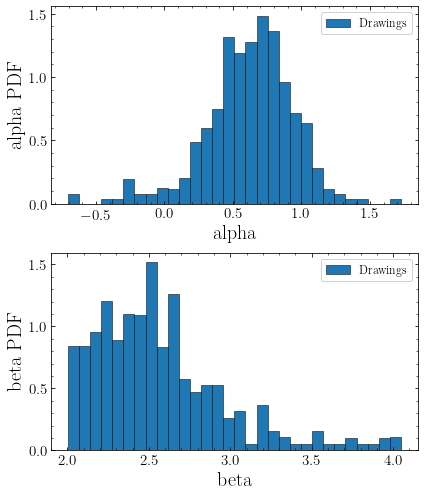

In [6]:
np.random.seed(0)
GRB_population = GRBPopulation(Nb_GRBs, output_dir=paths_to_dir['output'])
GRB_prop = GRB_population.draw_GRB_properties(cosmo=cosmo, params=params, run_mode='debug')

ph.calc_peak_photon_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
ph.calc_peak_energy_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
ph.calc_photon_fluence(GRB_prop, incl_instruments)
ph.calc_energy_fluence(GRB_prop, incl_instruments)
ph.calc_det_prob(GRB_prop, incl_samples, **ECLAIRs_prop)

df = pd.DataFrame(GRB_prop)

In [7]:
Stern_cond = df['pdet_Stern'] == 1
BATSE_5B_cond = df['pdet_BATSE_5B_sample'] == 1
eBAT6_cond = df['pdet_eBAT6'] == 1
EpGBM_cond = df['pdet_EpGBM'] == 1
GBM_cond = df['pdet_GBM_sample'] == 1
Swift_cond = df['pdet_Swift_bright'] == 1
# SHOALS_cond = df['pdet_SHOALS'] == 1

df_Stern = df[Stern_cond]
df_eBAT6 = df[eBAT6_cond]
df_BATSE_5B = df[BATSE_5B_cond]
df_EpGBM = df[EpGBM_cond]
df_GBM = df[GBM_cond]
df_Swift = df[Swift_cond]
# df_SHOALS = df[SHOALS_cond]

In [8]:

def plot_pht_pflx_flnc_plane(sample, fname, superfluous_cols,
                             obs_sname,
                             obs_pflx_key,
                             obs_flnc_key,
                             mod_pflx_key=None,
                             mod_flnc_key=None,
                             t90_key='t90',
                             bins_pflx=None,
                             bins_flnc=None,
                             long=False,
                             pflx_min=None,
                             color='C0',
                             verbose=False):
    """
        Convenience function to plot the photon peak flux - photon fluence plane for a given sample
    """
    
    
    # GRB pop model
    instr = incl_samples[sample]['instrument']
    Emin = incl_instruments[instr]['Emin']
    Emax = incl_instruments[instr]['Emax']
    cond = df[f'pdet_{sample}'] == 1

    # Observations
    df_obs = pd.read_csv(fname, sep='|', header=2, low_memory=False)
    for col in superfluous_cols:
       del df_obs[col]
    df_obs.rename(columns=lambda x:x.strip(), inplace=True)
    if verbose:
        print(df_obs.columns)
    for key in [obs_pflx_key, obs_flnc_key, t90_key]:
        df_obs[key] = pd.to_numeric(df_obs[key], errors='coerce')
    if long and pflx_min is not None:
        long_cut = (df_obs[t90_key] >= 2)
        pflx_cut = (df_obs[obs_pflx_key] >= pflx_min)
        cuts = long_cut & pflx_cut
    elif pflx_min is not None:
        pflx_cut = (df_obs[obs_pflx_key] >= pflx_min)
        cuts = pflx_cut
    else:
        cuts = np.isfinite(df_obs[obs_pflx_key]) & np.isfinite(df_obs[obs_flnc_key])
    df_obs = df_obs[cuts].dropna()
    
    if bins_pflx is None:
        bins_pflx = np.linspace(np.log10(pflx_min), np.log10(300.), 50)
    if bins_flnc is None:
        bins_flnc = np.linspace(np.log10(0.1), np.log10(3000.), 50)

    if mod_pflx_key is None:
        mod_pflx_key = f'pht_pflx_{instr}'
    if mod_flnc_key is None:
        mod_flnc_key = f'pht_flnc_{instr}'
    # Plot Model
    fig, axes = pf.cool_hist2d(x=np.log10(df[cond][mod_pflx_key].to_numpy()), 
                               y=np.log10(df[cond][mod_flnc_key].to_numpy()), cb=False, 
                               mode='hist2d', 
                               top_kdeplot_kwargs={'color': 'k', 'label': 'Model'},
                               left_kdeplot_kwargs={'color': 'k', 'label': None},
                               top_hist_kwargs={'color': 'gray','alpha':0.3,'bins':bins_pflx,'edgecolor':'k','linewidth':0.5},
                               left_hist_kwargs={'color': 'gray','alpha':0.3,'bins':bins_flnc,'edgecolor':'k','linewidth':0.5})
   

    # Plot observations
    pf.cool_hist2d(x=np.log10(df_obs[obs_pflx_key].to_numpy()), 
                   y=np.log10(df_obs[obs_flnc_key].to_numpy()),
                   fig=fig, cb=False, 
                   mode='hist2d', 
                   top_kdeplot_kwargs={'color': color, 'label': f'{obs_sname} catalog'},
                   left_kdeplot_kwargs={'color': color, 'label': None},
                   top_hist_kwargs={'color': color,'edgecolor':'k','linewidth':0.5,'bins':bins_pflx, 'alpha':0.3},
                   left_hist_kwargs={'color': color,'edgecolor':'k','linewidth':0.5,'bins':bins_flnc, 'alpha':0.3},
                   hist2d_kwargs={'plot_density':False,
                                  'plot_datapoints':False,
                                  'no_fill_contours':True,
                                  'contour_kwargs':{'colors':color}})


    axes['center'].set_xlabel(f'log peak flux [{Emin:.0f} keV - {Emax:.0f} keV]')
    axes['left'].set_ylabel(f'log fluence [{Emin:.0f} keV - {Emax:.0f} keV]')
    axes['left'].invert_xaxis()

    return fig, axes



/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


(<Figure size 648x504 with 3 Axes>,
 {'center': <matplotlib.axes._axes.Axes at 0x7fddc93c0940>,
  'left': <matplotlib.axes._axes.Axes at 0x7fddc93b4be0>,
  'top': <matplotlib.axes._axes.Axes at 0x7fddc93a8e48>})

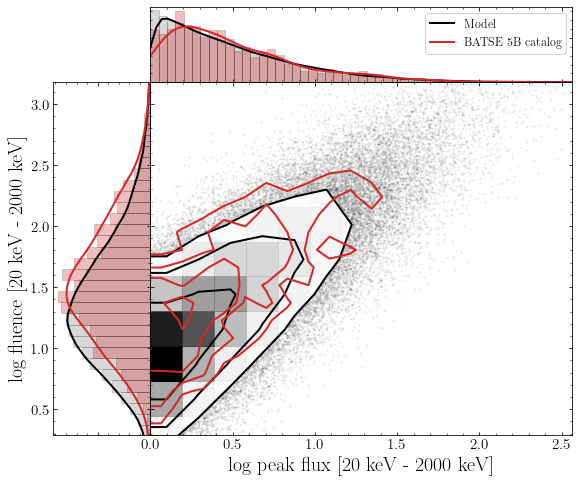

In [9]:
Goldstein_file = Path('../catalogs/BATSE_cat/BATSE_cat_complete_5B.txt')
sfl_cols = ['#%', 'Unnamed: 186']
plot_pht_pflx_flnc_plane(sample='BATSE_5B_sample',
                         fname=Goldstein_file,
                         superfluous_cols=sfl_cols,
                         obs_sname='BATSE 5B',
                         obs_pflx_key='pflx_band_phtflux',
                         obs_flnc_key='flnc_band_phtflnc',
                         long=True,
                         pflx_min=1.0,
                         color='C3')

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10


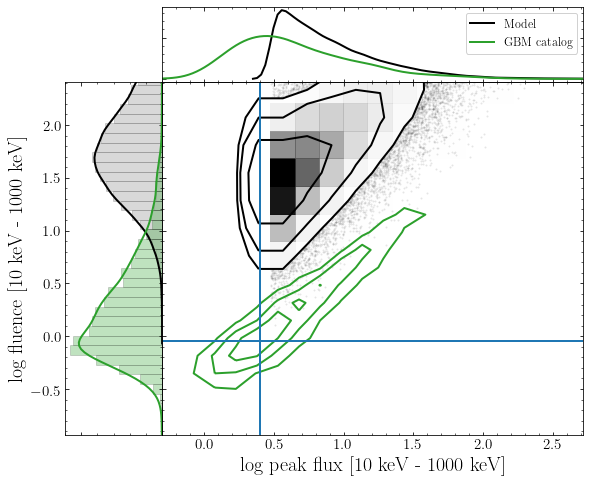

In [14]:
GBM_file = Path('../catalogs/GBM_cat/GBM_cat_complete2.txt')
sfl_cols = ['#%', 'Unnamed: 307']
plot_pht_pflx_flnc_plane(sample='GBM_sample',
                         fname=GBM_file,
                         superfluous_cols=sfl_cols,
                         obs_sname='GBM',
                         pflx_min=0.0,
                         obs_pflx_key='pflx_band_phtflux',
                         obs_flnc_key='pflx_band_phtfluxb',
                         long=True,
                         color='C2')
ax = plt.gcf().axes[0]
ax.axhline(np.log10(0.9))
ax.axvline(np.log10(2.5))

(<Figure size 648x504 with 3 Axes>,
 {'center': <matplotlib.axes._axes.Axes at 0x7fba622df0b8>,
  'left': <matplotlib.axes._axes.Axes at 0x7fba43d18898>,
  'top': <matplotlib.axes._axes.Axes at 0x7fba43a7ceb8>})

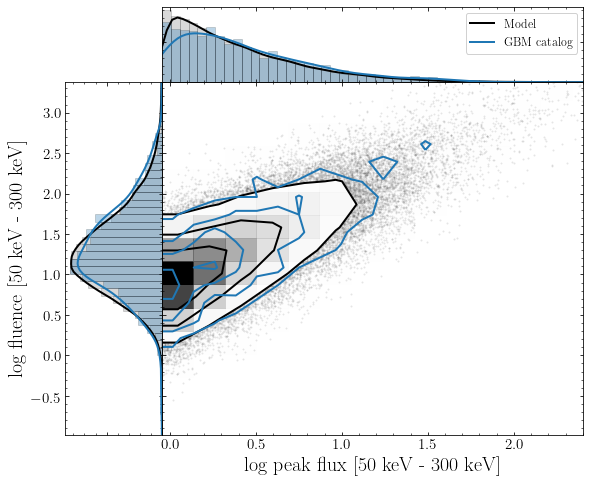

In [17]:
GBM_file = Path('../catalogs/GBM_cat/GBM_cat_complete2.txt')
sfl_cols = ['#%', 'Unnamed: 307']
plot_pht_pflx_flnc_plane(sample='EpGBM',
                         fname=GBM_file,
                         superfluous_cols=sfl_cols,
                         obs_sname='GBM',
                         pflx_min=0.9,
                         obs_pflx_key='pflx_band_phtfluxb',
                         obs_flnc_key='flnc_band_phtflncb',
                         long=True,
                         color='C0')

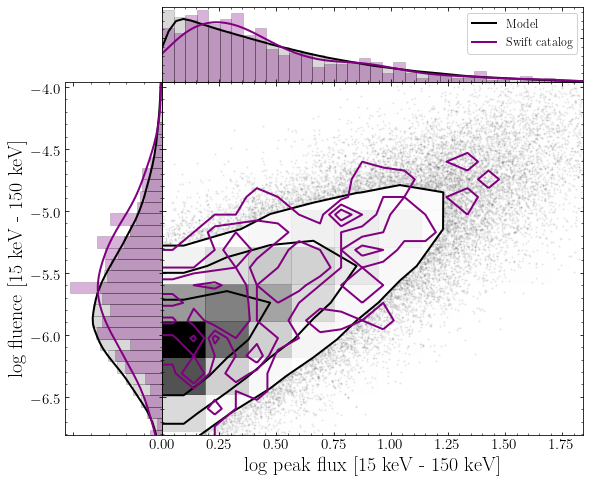

In [30]:
Swift_file = Path('../catalogs/Swift_cat/Swift_cat_complete.txt')
sfl_cols = ['#%', 'Unnamed: 179']
fig, axes = plot_pht_pflx_flnc_plane(sample='Swift_bright',
                         fname=Swift_file,
                         superfluous_cols=sfl_cols,
                         obs_sname='Swift',
                         pflx_min=1.0,
                         obs_pflx_key='bat_peakfluxp',
                         obs_flnc_key='bat_fluence',
                         mod_flnc_key='erg_flnc_BAT',
                         mod_pflx_key='pht_pflx_BAT',
                         bins_flnc=np.linspace(-7.5,-3, 50),
                         t90_key='bat_t90',
                         long=True,
                         color='purple')
